# Data summary

## Generate file list from CloudFront URL

## all TLC Trip file 
- **Yellow Taxi Trip Records (PARQUET)**
- **Green Taxi Trip Records (PARQUET)**
- **For-Hire Vehicle Trip Records (PARQUET)**
- **High Volume For-Hire Vehicle Trip Records (PARQUET)**

In [ ]:
# Generate all_files list from CloudFront URL
BASE_URL = "https://d37ci6vzurychx.cloudfront.net/trip-data"
TRIP_TYPES = ["yellow", "green", "fhv", "fhvhv"]
YEARS = list(range(2009, 2026))  # Adjust range as needed
MONTHS = list(range(1, 13))

all_files = []
for trip_type in TRIP_TYPES:
    for year in YEARS:
        for month in MONTHS:
            filename = f"{trip_type}_tripdata_{year}-{month:02d}.parquet"
            url = f"{BASE_URL}/{filename}"
            all_files.append(url)

print(f"Generated {len(all_files)} file URLs from CloudFront")


In [ ]:
# Build a tidy table from `all_files`, then summarize by year & trip type
import re
import pandas as pd
import pyarrow.parquet as pq
import requests

# 1) Keep only parquet files and parse trip_type/year/month from filename
pat = re.compile(r'(yellow|green|fhv|fhvhv)_tripdata_(\d{4})-(\d{2})', re.I)
rows = []
for url in all_files:
    if not url.lower().endswith(".parquet"): 
        continue
    # Extract filename from URL
    filename = url.split('/')[-1]
    m = pat.search(filename)
    if not m:
        continue
    trip_type, year, month = m.groups()
    
    # Get file size from HTTP HEAD request (for cloud URLs)
    size_bytes = None
    try:
        response = requests.head(url, timeout=5)
        if response.status_code == 200:
            size_bytes = int(response.headers.get('Content-Length', 0))
    except Exception:
        size_bytes = None
    
    # Row count via Parquet footer (works with URLs using fsspec)
    num_rows = None
    try:
        parquet_file = pq.ParquetFile(url)
        num_rows = parquet_file.metadata.num_rows
    except Exception:
        num_rows = None

    rows.append({
        "file_path": url,
        "trip_type": trip_type.lower(),
        "year": int(year),
        "month": int(month),
        "size_mb": (size_bytes / 1e6) if size_bytes is not None else None,
        "rows": num_rows
    })

df_files = pd.DataFrame(rows).sort_values(["trip_type","year","month"]).reset_index(drop=True)

# 2) Year × type: how many monthly files you have
files_per_year = df_files.groupby(["year","trip_type"]).size().unstack(fill_value=0)
display(files_per_year)

# 3) Year × type: total disk size (MB)
size_per_year = df_files.pivot_table(index="year", columns="trip_type", values="size_mb", aggfunc="sum", fill_value=0).round(1)
display(size_per_year)

# 4) Year × type: total rows (from metadata)
rows_per_year = df_files.pivot_table(index="year", columns="trip_type", values="rows", aggfunc="sum", fill_value=0)
display(rows_per_year)

# 5) Quick overview prints
print("\nTotals by type (files / GB / rows):")
tot = df_files.groupby("trip_type").agg(
    files=("file_path","count"),
    gb=("size_mb", lambda s: (s.sum() or 0)/1024),
    rows=("rows","sum")
).sort_values("rows", ascending=False)
display(tot.round({"gb":2}))


,file_path,trip_type,year,month,size_mb,rows
0,/Users/vidushi/Documents/Datasets/big_data/nyc...,fhv,2015,2,13.671243,3053183
1,/Users/vidushi/Documents/Datasets/big_data/nyc...,fhv,2015,12,35.365052,8888809
2,/Users/vidushi/Documents/Datasets/big_data/nyc...,fhv,2019,2,15.282636,1707650
3,/Users/vidushi/Documents/Datasets/big_data/nyc...,fhv,2019,12,19.638634,2044196
4,/Users/vidushi/Documents/Datasets/big_data/nyc...,fhv,2024,1,15.023585,1290116
5,/Users/vidushi/Documents/Datasets/big_data/nyc...,fhv,2024,2,13.608941,1176093
6,/Users/vidushi/Documents/Datasets/big_data/nyc...,fhv,2024,3,16.743352,1469352
7,/Users/vidushi/Documents/Datasets/big_data/nyc...,fhv,2024,4,16.515459,1444626
8,/Users/vidushi/Documents/Datasets/big_data/nyc...,fhv,2024,5,15.958984,1352502
9,/Users/vidushi/Documents/Datasets/big_data/nyc...,fhv,2024,6,16.029924,1386539


trip_type,fhv,fhvhv,green,yellow
year,,,,
2009,0,0,0,2
2014,0,0,2,2
2015,2,0,2,2
2019,2,2,2,2
2024,12,12,12,12
2025,8,8,8,8


trip_type,fhv,fhvhv,green,yellow
year,,,,
2009,0.0,0.0,0.0,931.0
2014,0.0,0.0,39.7,341.2
2015,49.0,0.0,47.9,331.5
2019,34.9,1089.7,17.8,204.4
2024,201.2,5776.0,15.9,693.0
2025,176.6,3916.7,9.7,537.4


trip_type,fhv,fhvhv,green,yellow
year,,,,
2009,0,0,0,27963526
2014,0,0,2651029,26175911
2015,11941992,0,3183127,23895390
2019,3751846,42403003,1070888,13945687
2024,17630326,239470448,660218,41169720
2025,16246142,159919664,397918,31556438



Totals by type (files / GB / rows):


,files,gb,rows
trip_type,,,
fhvhv,22,10.53,441793115
yellow,28,2.97,164706672
fhv,24,0.45,49570306
green,26,0.13,7963180


## trend and composition visuals

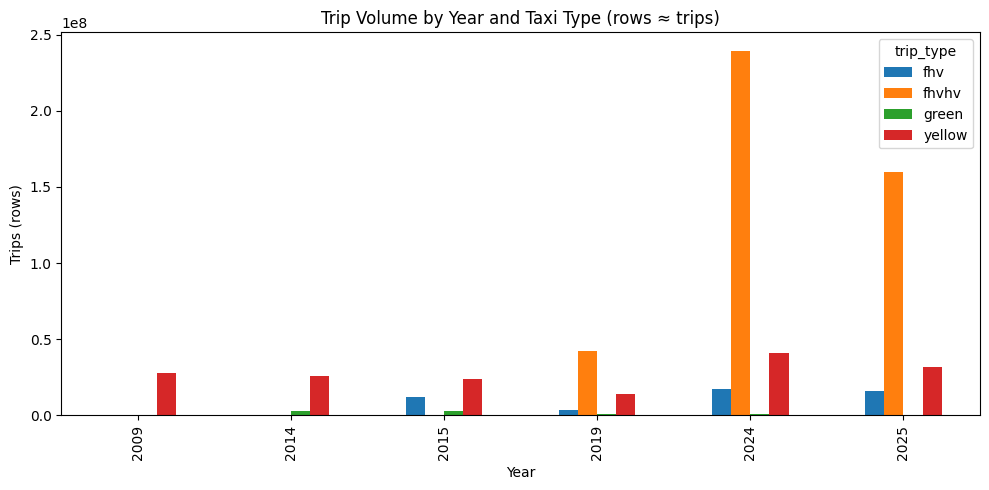

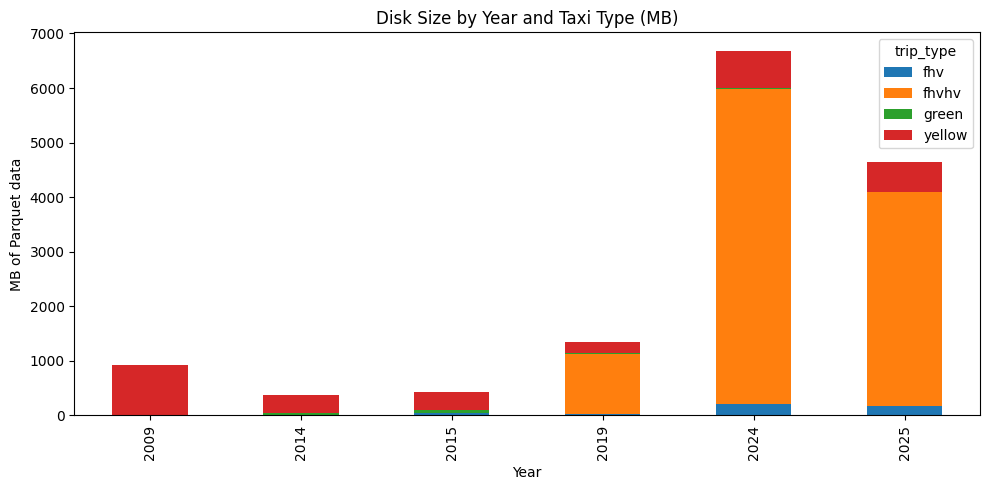

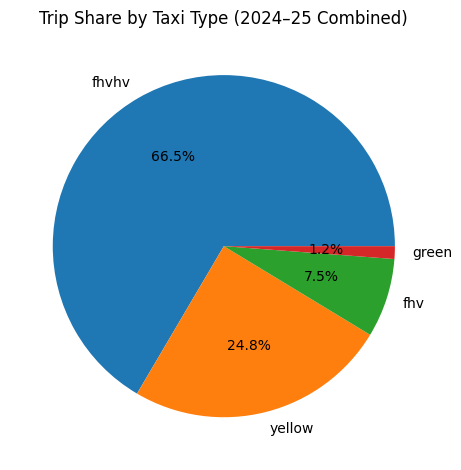

In [3]:
# 1️⃣  trip volumes (rows) by year/type
import matplotlib.pyplot as plt

rows_per_year.plot(kind="bar", figsize=(10,5))
plt.title("Trip Volume by Year and Taxi Type (rows ≈ trips)")
plt.ylabel("Trips (rows)")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

# 2️⃣  storage size by year/type
size_per_year.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("Disk Size by Year and Taxi Type (MB)")
plt.ylabel("MB of Parquet data")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

# 3️⃣  overall share for 2024–25 combined
share = (tot["rows"] / tot["rows"].sum() * 100).round(2)
share.plot(kind="pie", autopct="%1.1f%%", ylabel="")
plt.title("Trip Share by Taxi Type (2024–25 Combined)")
plt.tight_layout()
plt.show()


# Columns analyses:

## See what changed over years (e.g., new columns added)

In [4]:
import os
import re
import pandas as pd
import pyarrow.parquet as pq
from pathlib import Path

# === base directory ===
RAW = Path('/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/Raw_dataset')

# pattern to extract type/year/month
pat = re.compile(r'(yellow|green|fhv|fhvhv)_tripdata_(\d{4})-(\d{2})', re.I)

# known first year each type appears
start_years = {"yellow": 2009, "green": 2014, "fhv": 2015, "fhvhv": 2019}

# 1️⃣ collect schemas for all files
schema_records = []
for f in RAW.glob("*.parquet"):
    m = pat.search(f.name)
    if not m:
        continue
    t, y, mo = m.groups()
    t, y, mo = t.lower(), int(y), int(mo)
    try:
        cols = [c.lower() for c in pq.ParquetFile(f).schema_arrow.names]
        schema_records.append({"trip_type": t, "year": y, "month": mo, "file": f.name, "columns": cols})
    except Exception as e:
        print(f"⚠️ schema read failed for {f.name}: {e}")

df_schema = pd.DataFrame(schema_records)
print(f"✅ Collected schema info for {len(df_schema)} files")

# 2️⃣ function: analyze schema evolution per type relative to first year
def analyze_schema_relative(trip_type):
    print(f"\n🔍 Analyzing schema evolution for {trip_type.upper()}")
    g = df_schema[df_schema["trip_type"] == trip_type].copy()
    if g.empty:
        print("⚠️ No files found for this trip type.")
        return None

    g = g.sort_values(["year", "month"]).reset_index(drop=True)

    # union all months per year → single schema per year
    year_cols = {}
    for y, gy in g.groupby("year"):
        cols = set()
        for c in gy["columns"]:
            cols |= set(c)
        year_cols[y] = cols

    years = sorted(year_cols.keys())
    print(f"Years found: {years}")

    # establish baseline (first year schema)
    base_year = min(years)
    base_cols = year_cols[base_year]
    print(f"Baseline year: {base_year} | Columns: {len(base_cols)}")

    reports = []
    for y in years:
        cur_cols = year_cols[y]
        added = sorted(list(cur_cols - base_cols)) if y != base_year else []
        removed = sorted(list(base_cols - cur_cols)) if y != base_year else []
        reports.append({
            "trip_type": trip_type,
            "year": y,
            "total_columns": len(cur_cols),
            "original_columns": sorted(list(base_cols)) if y == base_year else None,
            "added_columns": added,
            "removed_columns": removed,
            "added_count": len(added),
            "removed_count": len(removed)
        })

    df_report = pd.DataFrame(reports)
    display(df_report[["year","total_columns","added_count","removed_count"]])

    for _, r in df_report.iterrows():
        print(f"\n🗓️ {trip_type.upper()} - {r['year']}")
        print(f"Total columns: {r['total_columns']}")
        if r["year"] == base_year:
            print("📘 Original baseline columns:")
            print(r["original_columns"])
        if r["added_columns"]:
            print("🆕 Added columns:", r["added_columns"])
        if r["removed_columns"]:
            print("❌ Removed columns:", r["removed_columns"])
    return df_report, base_cols

# 3️⃣ run for all types & store results
reports = {}
baselines = {}
for t in ["yellow", "green", "fhv", "fhvhv"]:
    rep, base = analyze_schema_relative(t)
    reports[t] = rep
    baselines[t] = base

# 4️⃣ optional: combine summary overview for documentation
summary = pd.concat([r.assign(original_year=min(r["year"])) for r in reports.values()])
summary = summary.sort_values(["trip_type","year"])
display(summary[["trip_type","year","total_columns","added_count","removed_count"]])


✅ Collected schema info for 100 files

🔍 Analyzing schema evolution for YELLOW
Years found: [2009, 2014, 2015, 2019, 2024, 2025]
Baseline year: 2009 | Columns: 18


,year,total_columns,added_count,removed_count
0,2009,18,0,0
1,2014,19,15,14
2,2015,19,15,14
3,2019,19,15,14
4,2024,19,15,14
5,2025,20,16,14



🗓️ YELLOW - 2009
Total columns: 18
📘 Original baseline columns:
['end_lat', 'end_lon', 'fare_amt', 'mta_tax', 'passenger_count', 'payment_type', 'rate_code', 'start_lat', 'start_lon', 'store_and_forward', 'surcharge', 'tip_amt', 'tolls_amt', 'total_amt', 'trip_distance', 'trip_dropoff_datetime', 'trip_pickup_datetime', 'vendor_name']

🗓️ YELLOW - 2014
Total columns: 19
🆕 Added columns: ['airport_fee', 'congestion_surcharge', 'dolocationid', 'extra', 'fare_amount', 'improvement_surcharge', 'pulocationid', 'ratecodeid', 'store_and_fwd_flag', 'tip_amount', 'tolls_amount', 'total_amount', 'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'vendorid']
❌ Removed columns: ['end_lat', 'end_lon', 'fare_amt', 'rate_code', 'start_lat', 'start_lon', 'store_and_forward', 'surcharge', 'tip_amt', 'tolls_amt', 'total_amt', 'trip_dropoff_datetime', 'trip_pickup_datetime', 'vendor_name']

🗓️ YELLOW - 2015
Total columns: 19
🆕 Added columns: ['airport_fee', 'congestion_surcharge', 'dolocationid', 'extra', 

,year,total_columns,added_count,removed_count
0,2014,20,0,0
1,2015,20,0,0
2,2019,20,0,0
3,2024,20,0,0
4,2025,21,1,0



🗓️ GREEN - 2014
Total columns: 20
📘 Original baseline columns:
['congestion_surcharge', 'dolocationid', 'ehail_fee', 'extra', 'fare_amount', 'improvement_surcharge', 'lpep_dropoff_datetime', 'lpep_pickup_datetime', 'mta_tax', 'passenger_count', 'payment_type', 'pulocationid', 'ratecodeid', 'store_and_fwd_flag', 'tip_amount', 'tolls_amount', 'total_amount', 'trip_distance', 'trip_type', 'vendorid']

🗓️ GREEN - 2015
Total columns: 20

🗓️ GREEN - 2019
Total columns: 20

🗓️ GREEN - 2024
Total columns: 20

🗓️ GREEN - 2025
Total columns: 21
🆕 Added columns: ['cbd_congestion_fee']

🔍 Analyzing schema evolution for FHV
Years found: [2015, 2019, 2024, 2025]
Baseline year: 2015 | Columns: 7


,year,total_columns,added_count,removed_count
0,2015,7,0,0
1,2019,7,0,0
2,2024,7,0,0
3,2025,7,0,0



🗓️ FHV - 2015
Total columns: 7
📘 Original baseline columns:
['affiliated_base_number', 'dispatching_base_num', 'dolocationid', 'dropoff_datetime', 'pickup_datetime', 'pulocationid', 'sr_flag']

🗓️ FHV - 2019
Total columns: 7

🗓️ FHV - 2024
Total columns: 7

🗓️ FHV - 2025
Total columns: 7

🔍 Analyzing schema evolution for FHVHV
Years found: [2019, 2024, 2025]
Baseline year: 2019 | Columns: 24


,year,total_columns,added_count,removed_count
0,2019,24,0,0
1,2024,24,0,0
2,2025,25,1,0



🗓️ FHVHV - 2019
Total columns: 24
📘 Original baseline columns:
['access_a_ride_flag', 'airport_fee', 'base_passenger_fare', 'bcf', 'congestion_surcharge', 'dispatching_base_num', 'dolocationid', 'driver_pay', 'dropoff_datetime', 'hvfhs_license_num', 'on_scene_datetime', 'originating_base_num', 'pickup_datetime', 'pulocationid', 'request_datetime', 'sales_tax', 'shared_match_flag', 'shared_request_flag', 'tips', 'tolls', 'trip_miles', 'trip_time', 'wav_match_flag', 'wav_request_flag']

🗓️ FHVHV - 2024
Total columns: 24

🗓️ FHVHV - 2025
Total columns: 25
🆕 Added columns: ['cbd_congestion_fee']


,trip_type,year,total_columns,added_count,removed_count
0,fhv,2015,7,0,0
1,fhv,2019,7,0,0
2,fhv,2024,7,0,0
3,fhv,2025,7,0,0
0,fhvhv,2019,24,0,0
1,fhvhv,2024,24,0,0
2,fhvhv,2025,25,1,0
0,green,2014,20,0,0
1,green,2015,20,0,0
2,green,2019,20,0,0


# data dictionary for  all trip types

## Dynamic data-dictionary per trip_type × year

In [5]:
import re, warnings
from pathlib import Path
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

RAW = Path('/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/Raw_dataset')
pat = re.compile(r'(yellow|green|fhv|fhvhv)_tripdata_(\d{4})-(\d{2})', re.I)

# --- inventory all files we actually have ---
inv = []
for f in RAW.glob("*.parquet"):
    m = pat.search(f.name)
    if m:
        t, y, mo = m.groups()
        inv.append({"trip_type": t.lower(), "year": int(y), "month": int(mo), "file_path": f})
df_files = (pd.DataFrame(inv)
            .sort_values(["trip_type","year","month"])
            .reset_index(drop=True))

print(f"✅ Collected {len(df_files)} files")

# --- helper: get dtype map from a parquet file quickly (pyarrow schema) ---
def parquet_dtypes_map(p: Path) -> dict:
    sch = pq.ParquetFile(p).schema_arrow
    return {n.lower(): str(sch.field(n).type) for n in sch.names}

# --- helper: get ONE sample value for selected columns from earliest row group ---
def parquet_sample_values(p: Path, columns: list[str], max_try=2) -> dict:
    out = {c: None for c in columns}
    pf = pq.ParquetFile(p)
    # try row group 0, then 1 (some files may have an empty first RG for metadata reasons)
    for rg in range(min(max_try, pf.num_row_groups or 1)):
        try:
            tab = pf.read_row_group(rg, columns=columns)
            if tab.num_rows > 0:
                pdf = tab.to_pandas()
                if len(pdf):
                    row0 = pdf.iloc[0]
                    for c in columns:
                        val = row0.get(c)
                        # normalize tiny numpy types to python scalars for display
                        if isinstance(val, (pa.Scalar,)):
                            val = val.as_py()
                        out[c] = None if pd.isna(val) else val
                    break
        except Exception:
            continue
    return out

# --- build per-year column sets and select a representative file per (type,year) ---
year_union_cols = {}      # (type,year) -> set(columns)
year_rep_file   = {}      # (type,year) -> Path
for (t,y), g in df_files.groupby(["trip_type","year"]):
    cols = set()
    # pick earliest month file as representative for samples/dtypes
    rep = g.sort_values("month").iloc[0]["file_path"]
    year_rep_file[(t,y)] = rep
    for p in g["file_path"]:
        try:
            cols |= set(n.lower() for n in pq.ParquetFile(p).schema_arrow.names)
        except Exception as e:
            warnings.warn(f"Schema read failed {p.name}: {e}")
    year_union_cols[(t,y)] = cols

# --- per-type baseline (first observed year for that type in your local files) ---
baseline_year = {t: int(gs["year"].min()) for t, gs in df_files.groupby("trip_type")}
print("Baseline (first seen) year per type:", baseline_year)

# === OUTPUTS ===
# 1) yearly_summary[t]: rows per year with lists of original/added/removed columns (relative to baseline)
# 2) yearly_dict[t]: detailed per-year data dictionary (column, status, dtype, sample_value)
yearly_summary, yearly_dict = {}, {}

for t, g in df_files.groupby("trip_type"):
    by_year = sorted(set(g["year"]))
    base_y  = baseline_year[t]
    base_cols = year_union_cols[(t, base_y)]

    # (a) Yearly summary (original/added/removed lists)
    rows = []
    for y in by_year:
        cols = year_union_cols[(t,y)]
        if y == base_y:
            original = sorted(cols)                 # baseline = "original"
            added, removed = [], []
        else:
            original = sorted(cols & base_cols)
            added    = sorted(cols - base_cols)
            removed  = sorted(base_cols - cols)
        rows.append({
            "trip_type": t, "year": y,
            "total_columns": len(cols),
            "original_columns": original,
            "added_columns": added,
            "removed_columns": removed,
            "added_count": len(added),
            "removed_count": len(removed)
        })
    yearly_summary[t] = pd.DataFrame(rows).sort_values("year")

    # (b) Detailed per-year dictionary with dtype + one sample value
    dict_rows = []
    for y in by_year:
        cols = sorted(year_union_cols[(t,y)])
        repf = year_rep_file[(t,y)]
        dtypes = parquet_dtypes_map(repf)
        samples = parquet_sample_values(repf, cols)

        # status per column (relative to baseline)
        for c in cols:
            status = "original" if c in base_cols else "added"
            dict_rows.append({
                "trip_type": t, "year": y, "column": c,
                "status_vs_baseline": status,
                "dtype": dtypes.get(c, None),
                "sample_value": samples.get(c, None)
            })
        # also capture columns removed (present in baseline but not in this year)
        removed_cols = sorted(base_cols - set(cols)) if y != base_y else []
        for c in removed_cols:
            dict_rows.append({
                "trip_type": t, "year": y, "column": c,
                "status_vs_baseline": "removed",
                "dtype": None, "sample_value": None
            })

    yearly_dict[t] = (pd.DataFrame(dict_rows)
                      .sort_values(["year","status_vs_baseline","column"])
                      .reset_index(drop=True))

# --- Display examples (you can save to CSV as needed) ---
for t in ["yellow","green","fhv","fhvhv"]:
    print("\n====", t.upper(), "— YEARLY SUMMARY ====")
    display(yearly_summary[t][["year","total_columns","added_count","removed_count"]])
    print("…columns for latest year preview:")
    latest_y = yearly_summary[t]["year"].max()
    display(yearly_dict[t][yearly_dict[t]["year"]==latest_y].head(15))


✅ Collected 100 files
Baseline (first seen) year per type: {'fhv': 2015, 'fhvhv': 2019, 'green': 2014, 'yellow': 2009}

==== YELLOW — YEARLY SUMMARY ====


,year,total_columns,added_count,removed_count
0,2009,18,0,0
1,2014,19,15,14
2,2015,19,15,14
3,2019,19,15,14
4,2024,19,15,14
5,2025,20,16,14


…columns for latest year preview:


,trip_type,year,column,status_vs_baseline,dtype,sample_value
150,yellow,2025,airport_fee,added,double,None
151,yellow,2025,cbd_congestion_fee,added,double,0.0
152,yellow,2025,congestion_surcharge,added,double,2.5
153,yellow,2025,dolocationid,added,int32,None
154,yellow,2025,extra,added,double,3.5
155,yellow,2025,fare_amount,added,double,10.0
156,yellow,2025,improvement_surcharge,added,double,1.0
157,yellow,2025,pulocationid,added,int32,None
158,yellow,2025,ratecodeid,added,int64,None
159,yellow,2025,store_and_fwd_flag,added,large_string,N



==== GREEN — YEARLY SUMMARY ====


,year,total_columns,added_count,removed_count
0,2014,20,0,0
1,2015,20,0,0
2,2019,20,0,0
3,2024,20,0,0
4,2025,21,1,0


…columns for latest year preview:


,trip_type,year,column,status_vs_baseline,dtype,sample_value
80,green,2025,cbd_congestion_fee,added,double,0.0
81,green,2025,congestion_surcharge,original,double,0.0
82,green,2025,dolocationid,original,int32,None
83,green,2025,ehail_fee,original,double,None
84,green,2025,extra,original,double,1.0
85,green,2025,fare_amount,original,double,24.7
86,green,2025,improvement_surcharge,original,double,1.0
87,green,2025,lpep_dropoff_datetime,original,timestamp[us],2025-01-01 00:17:12
88,green,2025,lpep_pickup_datetime,original,timestamp[us],2025-01-01 00:03:01
89,green,2025,mta_tax,original,double,0.5



==== FHV — YEARLY SUMMARY ====


,year,total_columns,added_count,removed_count
0,2015,7,0,0
1,2019,7,0,0
2,2024,7,0,0
3,2025,7,0,0


…columns for latest year preview:


,trip_type,year,column,status_vs_baseline,dtype,sample_value
21,fhv,2025,affiliated_base_number,original,large_string,None
22,fhv,2025,dispatching_base_num,original,large_string,B00009
23,fhv,2025,dolocationid,original,int64,None
24,fhv,2025,dropoff_datetime,original,timestamp[us],None
25,fhv,2025,pickup_datetime,original,timestamp[us],2025-01-01 00:20:00
26,fhv,2025,pulocationid,original,int64,None
27,fhv,2025,sr_flag,original,int64,None



==== FHVHV — YEARLY SUMMARY ====


,year,total_columns,added_count,removed_count
0,2019,24,0,0
1,2024,24,0,0
2,2025,25,1,0


…columns for latest year preview:


,trip_type,year,column,status_vs_baseline,dtype,sample_value
48,fhvhv,2025,cbd_congestion_fee,added,double,0.0
49,fhvhv,2025,access_a_ride_flag,original,large_string,N
50,fhvhv,2025,airport_fee,original,double,0.0
51,fhvhv,2025,base_passenger_fare,original,double,18.21
52,fhvhv,2025,bcf,original,double,0.46
53,fhvhv,2025,congestion_surcharge,original,double,2.75
54,fhvhv,2025,dispatching_base_num,original,large_string,B03404
55,fhvhv,2025,dolocationid,original,int32,None
56,fhvhv,2025,driver_pay,original,double,15.71
57,fhvhv,2025,dropoff_datetime,original,timestamp[us],2025-01-01 00:54:24


## “Maintained columns” dictionary (persist from first appearance through 2025)

In [6]:
import numpy as np

# build presence map: (type -> {year -> set(cols)})
presence = {}
for (t,y), cols in year_union_cols.items():
    presence.setdefault(t, {})[y] = set(cols)

maintained_dict = {}  # trip_type -> DataFrame

for t, years_map in presence.items():
    years = sorted(years_map.keys())
    last_year = max(years)  # latest available in your files

    # first and last observed year per column
    first_seen, last_seen = {}, {}
    for y in years:
        for c in years_map[y]:
            first_seen.setdefault(c, y)
            last_seen[c] = y

    # maintained = present for all observed years from its first appearance through the latest year
    maintained_cols = []
    for c, y0 in first_seen.items():
        ok = True
        for y in [yy for yy in years if yy >= y0]:
            if c not in years_map[y]:
                ok = False
                break
        if ok:
            maintained_cols.append(c)

    maintained_cols = sorted(maintained_cols)

    # collect dtype + one sample value from the latest-year representative file
    rep_latest = year_rep_file[(t, last_year)]
    latest_dtypes = parquet_dtypes_map(rep_latest)
    latest_samples = parquet_sample_values(rep_latest, maintained_cols) if maintained_cols else {}

    rows = []
    for c in maintained_cols:
        rows.append({
            "trip_type": t,
            "first_year": first_seen[c],
            "last_year": last_seen[c],
            "column": c,
            "dtype_latest": latest_dtypes.get(c, None),
            "sample_latest": latest_samples.get(c, None)
        })
    maintained_df = pd.DataFrame(rows).sort_values(["first_year","column"]).reset_index(drop=True)
    maintained_dict[t] = maintained_df

# Display maintained dictionaries
for t in ["yellow","green","fhv","fhvhv"]:
    print("\n====", t.upper(), "— MAINTAINED COLUMNS (first → latest) ====")
    display(maintained_dict[t])



==== YELLOW — MAINTAINED COLUMNS (first → latest) ====


,trip_type,first_year,last_year,column,dtype_latest,sample_latest
0,yellow,2009,2025,mta_tax,double,0.5
1,yellow,2009,2025,passenger_count,int64,1
2,yellow,2009,2025,payment_type,int64,1
3,yellow,2009,2025,trip_distance,double,1.6
4,yellow,2014,2025,airport_fee,double,None
5,yellow,2014,2025,congestion_surcharge,double,2.5
6,yellow,2014,2025,dolocationid,int32,None
7,yellow,2014,2025,extra,double,3.5
8,yellow,2014,2025,fare_amount,double,10.0
9,yellow,2014,2025,improvement_surcharge,double,1.0



==== GREEN — MAINTAINED COLUMNS (first → latest) ====


,trip_type,first_year,last_year,column,dtype_latest,sample_latest
0,green,2014,2025,congestion_surcharge,double,0.0
1,green,2014,2025,dolocationid,int32,None
2,green,2014,2025,ehail_fee,double,None
3,green,2014,2025,extra,double,1.0
4,green,2014,2025,fare_amount,double,24.7
5,green,2014,2025,improvement_surcharge,double,1.0
6,green,2014,2025,lpep_dropoff_datetime,timestamp[us],2025-01-01 00:17:12
7,green,2014,2025,lpep_pickup_datetime,timestamp[us],2025-01-01 00:03:01
8,green,2014,2025,mta_tax,double,0.5
9,green,2014,2025,passenger_count,int64,1.0



==== FHV — MAINTAINED COLUMNS (first → latest) ====


,trip_type,first_year,last_year,column,dtype_latest,sample_latest
0,fhv,2015,2025,affiliated_base_number,large_string,None
1,fhv,2015,2025,dispatching_base_num,large_string,B00009
2,fhv,2015,2025,dolocationid,int64,None
3,fhv,2015,2025,dropoff_datetime,timestamp[us],None
4,fhv,2015,2025,pickup_datetime,timestamp[us],2025-01-01 00:20:00
5,fhv,2015,2025,pulocationid,int64,None
6,fhv,2015,2025,sr_flag,int64,None



==== FHVHV — MAINTAINED COLUMNS (first → latest) ====


,trip_type,first_year,last_year,column,dtype_latest,sample_latest
0,fhvhv,2019,2025,access_a_ride_flag,large_string,N
1,fhvhv,2019,2025,airport_fee,double,0.0
2,fhvhv,2019,2025,base_passenger_fare,double,18.21
3,fhvhv,2019,2025,bcf,double,0.46
4,fhvhv,2019,2025,congestion_surcharge,double,2.75
5,fhvhv,2019,2025,dispatching_base_num,large_string,B03404
6,fhvhv,2019,2025,dolocationid,int32,None
7,fhvhv,2019,2025,driver_pay,double,15.71
8,fhvhv,2019,2025,dropoff_datetime,timestamp[us],2025-01-01 00:54:24
9,fhvhv,2019,2025,hvfhs_license_num,large_string,HV0003


In [7]:
# import os
# from pathlib import Path

# OUT = Path("/Users/vidushi/Documents/Sem2/Big_data/project/data_dictionary")  
# OUT.mkdir(exist_ok=True)

# # 1️⃣  yearly summaries (schema changes by year)
# for t, df in yearly_summary.items():
#     p = OUT / f"{t}_schema_yearly_summary.csv"
#     df.to_csv(p, index=False)
#     print(f"📝 saved: {p}")

# # 2️⃣  yearly data dictionaries (column, status_vs_baseline, dtype, sample)
# for t, df in yearly_dict.items():
#     p = OUT / f"{t}_data_dictionary_by_year.csv"
#     df.to_csv(p, index=False)
#     print(f"📝 saved: {p}")

# # 3️⃣  maintained columns (persistent from first → latest)
# for t, df in maintained_dict.items():
#     p = OUT / f"{t}_maintained_columns.csv"
#     df.to_csv(p, index=False)
#     print(f"📝 saved: {p}")

# print("\n✅ All schema and data-dictionary CSVs written to:", OUT.resolve())


import pandas as pd
from pathlib import Path

OUT = Path("/Users/vidushi/Documents/Sem2/Big_data/project/data_dictionary")
OUT.mkdir(exist_ok=True)

master_rows = []

# 1️⃣  yearly summaries
for t, df in yearly_summary.items():
    tmp = df.copy()
    tmp["section_type"] = "yearly_summary"
    tmp["trip_type"] = t
    master_rows.append(tmp)

# 2️⃣  yearly detailed dictionaries
for t, df in yearly_dict.items():
    tmp = df.copy()
    tmp["section_type"] = "yearly_dict"
    tmp["trip_type"] = t
    master_rows.append(tmp)

# 3️⃣  maintained columns
for t, df in maintained_dict.items():
    tmp = df.copy()
    tmp["section_type"] = "maintained_columns"
    tmp["trip_type"] = t
    master_rows.append(tmp)

# 🧱 combine everything into one master DataFrame
master_df = pd.concat(master_rows, ignore_index=True)

# reorder a few common columns up front for readability
common_order = [c for c in [
    "section_type", "trip_type", "year",
    "column", "status_vs_baseline", "dtype", "dtype_latest",
    "sample_value", "sample_latest",
    "total_columns", "added_count", "removed_count"
] if c in master_df.columns]
master_df = master_df[common_order + [c for c in master_df.columns if c not in common_order]]

# write one master file
out_path = OUT / "nyc_tlc_schema_data_dictionary_master.csv"
master_df.to_csv(out_path, index=False)
print(f"✅ Master schema dictionary written to:\n{out_path.resolve()}")

# optional: quick peek
display(master_df.head(10))



✅ Master schema dictionary written to:
/Users/vidushi/Documents/Sem2/Big_data/project/data_dictionary/nyc_tlc_schema_data_dictionary_master.csv


,section_type,trip_type,year,column,status_vs_baseline,dtype,dtype_latest,sample_value,sample_latest,total_columns,added_count,removed_count,original_columns,added_columns,removed_columns,first_year,last_year
0,yearly_summary,fhv,2015.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,0.0,"[affiliated_base_number, dispatching_base_num,...",[],[],NaN,NaN
1,yearly_summary,fhv,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,0.0,"[affiliated_base_number, dispatching_base_num,...",[],[],NaN,NaN
2,yearly_summary,fhv,2024.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,0.0,"[affiliated_base_number, dispatching_base_num,...",[],[],NaN,NaN
3,yearly_summary,fhv,2025.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,0.0,"[affiliated_base_number, dispatching_base_num,...",[],[],NaN,NaN
4,yearly_summary,fhvhv,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,0.0,0.0,"[access_a_ride_flag, airport_fee, base_passeng...",[],[],NaN,NaN
5,yearly_summary,fhvhv,2024.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,0.0,0.0,"[access_a_ride_flag, airport_fee, base_passeng...",[],[],NaN,NaN
6,yearly_summary,fhvhv,2025.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,1.0,0.0,"[access_a_ride_flag, airport_fee, base_passeng...",[cbd_congestion_fee],[],NaN,NaN
7,yearly_summary,green,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,0.0,0.0,"[congestion_surcharge, dolocationid, ehail_fee...",[],[],NaN,NaN
8,yearly_summary,green,2015.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,0.0,0.0,"[congestion_surcharge, dolocationid, ehail_fee...",[],[],NaN,NaN
9,yearly_summary,green,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,0.0,0.0,"[congestion_surcharge, dolocationid, ehail_fee...",[],[],NaN,NaN


## Data mapping

In [8]:
import pandas as pd
from pathlib import Path

# Load your master data dictionary
df = pd.read_csv("/Users/vidushi/Documents/Sem2/Big_data/project/data_dictionary/nyc_tlc_schema_data_dictionary_master.csv")

# Filter only maintained columns
maint = df[df["section_type"] == "maintained_columns"].copy()

# --- Canonical name + role helpers ---
def canonical_name(c):
    c = c.lower()
    rename = {
        "tpep_pickup_datetime": "pickup_datetime",
        "lpep_pickup_datetime": "pickup_datetime",
        "tpep_dropoff_datetime": "dropoff_datetime",
        "lpep_dropoff_datetime": "dropoff_datetime",
        "pulocationid": "pu_location_id",
        "dolocationid": "do_location_id",
        "vendorid": "vendor_id",
        "ratecodeid": "rate_code_id"
    }
    return rename.get(c, c)

def column_role(canon):
    if canon in ["pickup_datetime", "dropoff_datetime"]:
        return "time"
    if canon in ["pu_location_id", "do_location_id"]:
        return "spatial"
    if any(x in canon for x in ["amount", "fee", "tax", "fare"]):
        return "fare_economics"
    if "trip" in canon or "passenger" in canon:
        return "trip_metrics"
    if "flag" in canon:
        return "flags"
    return "other"

# Apply canonical naming and assign logical roles
maint["canonical_column"] = maint["column"].apply(canonical_name)
maint["role"] = maint["canonical_column"].apply(column_role)

# Project-useful subset (without first/last year)
project_dict = maint[[
    "trip_type", "canonical_column", "role", "dtype_latest", "sample_latest"
]].rename(columns={"dtype_latest": "dtype", "sample_latest": "sample"})

# Source→canonical mapping (without first/last year)
mapping = maint.rename(columns={
    "column": "source_column",
    "dtype_latest": "dtype",
    "sample_latest": "sample"
})[["trip_type", "source_column", "canonical_column", "role", "dtype", "sample"]]

# Canonical availability matrix
avail = (
    maint.assign(available=True)
    .pivot_table(index="canonical_column", columns="trip_type", values="available", aggfunc="any", fill_value=False)
    .reset_index()
)

# === Save outputs ===
base_path = Path("/Users/vidushi/Documents/Sem2/Big_data/project/data_dictionary")
project_path = base_path / "project_useful_data_dictionary.csv"
mapping_path = base_path / "project_source_to_canonical_mapping.csv"
avail_path   = base_path / "canonical_availability_by_type.csv"

project_dict.to_csv(project_path, index=False)
mapping.to_csv(mapping_path, index=False)
avail.to_csv(avail_path, index=False)

print("✅ Files saved:")
print(" -", project_path)
print(" -", mapping_path)
print(" -", avail_path)


✅ Files saved:
 - /Users/vidushi/Documents/Sem2/Big_data/project/data_dictionary/project_useful_data_dictionary.csv
 - /Users/vidushi/Documents/Sem2/Big_data/project/data_dictionary/project_source_to_canonical_mapping.csv
 - /Users/vidushi/Documents/Sem2/Big_data/project/data_dictionary/canonical_availability_by_type.csv


## CROSS-TYPE COLUMN MAPPING

## Data cleaning

In [23]:
# === CELL 1: RAW FILE PICKER + QUICK PROFILE ===
import os, re
from pathlib import Path
import pandas as pd
import pyarrow.parquet as pq

FOLDER = '/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/Raw_dataset'
EXCLUDE = {'2025_sep'}
PAT = re.compile(r'(yellow|green|fhv|fhvhv)_tripdata_(\d{4})-(\d{2})', re.I)

def list_parquet_files(folder, exclude_dirs):
    recs = []
    for root, dirs, files in os.walk(folder):
        dirs[:] = [d for d in dirs if d not in exclude_dirs]
        for f in files:
            if not f.endswith('.parquet'): 
                continue
            m = PAT.search(f)
            if not m:
                continue
            trip, y, mth = m.groups()
            recs.append({
                "trip_type": trip.lower(),
                "year": int(y),
                "month": int(mth),
                "file_name": f,
                "path": os.path.join(root, f),
            })
    return pd.DataFrame(recs)

df_files = list_parquet_files(FOLDER, EXCLUDE)
df_files = df_files.sort_values(["trip_type","year","month"]).reset_index(drop=True)
print(f"✅ Found {len(df_files)} parquet files")
display(df_files.head(20))

# ---- choose a file index to inspect (change this as you like) ----
FILE_IDX = 0  # <--- set which row from the table above to inspect

sel = df_files.iloc[FILE_IDX]
PATH = sel["path"]; TTYPE = sel["trip_type"]; YEAR = sel["year"]; MONTH = sel["month"]

# Read full file (arrow -> pandas preserves types nicely)
pf = pq.ParquetFile(PATH)
tab = pf.read()
df_raw = tab.to_pandas(types_mapper=pd.ArrowDtype)

print(f"\nSelected: {sel['file_name']} | type={TTYPE} | {YEAR}-{MONTH:02d} | rows={len(df_raw):,} cols={df_raw.shape[1]}")
print("Columns:", list(df_raw.columns))

# dtypes + NA ratios
dtypes = pd.Series({c: str(df_raw[c].dtype) for c in df_raw.columns}, name="dtype")
na = df_raw.isna().mean().rename("na_ratio")
summary = pd.concat([dtypes, na], axis=1).sort_values("na_ratio", ascending=False)
display(summary.head(30))

# time span if time columns exist
time_pairs = [
    ("tpep_pickup_datetime","tpep_dropoff_datetime"),
    ("lpep_pickup_datetime","lpep_dropoff_datetime"),
    ("pickup_datetime","dropoff_datetime"),
]
for pc, dc in time_pairs:
    if pc in df_raw.columns and dc in df_raw.columns:
        print(f"Time span ({pc}/{dc}): {df_raw[pc].min()} → {df_raw[pc].max()}")
        break

df_raw.head(5)


✅ Found 100 parquet files


,trip_type,year,month,file_name,path
0,fhv,2015,2,fhv_tripdata_2015-02.parquet,/Users/vidushi/Documents/Datasets/big_data/nyc...
1,fhv,2015,12,fhv_tripdata_2015-12.parquet,/Users/vidushi/Documents/Datasets/big_data/nyc...
2,fhv,2019,2,fhv_tripdata_2019-02.parquet,/Users/vidushi/Documents/Datasets/big_data/nyc...
3,fhv,2019,12,fhv_tripdata_2019-12.parquet,/Users/vidushi/Documents/Datasets/big_data/nyc...
4,fhv,2024,1,fhv_tripdata_2024-01.parquet,/Users/vidushi/Documents/Datasets/big_data/nyc...
5,fhv,2024,2,fhv_tripdata_2024-02.parquet,/Users/vidushi/Documents/Datasets/big_data/nyc...
6,fhv,2024,3,fhv_tripdata_2024-03.parquet,/Users/vidushi/Documents/Datasets/big_data/nyc...
7,fhv,2024,4,fhv_tripdata_2024-04.parquet,/Users/vidushi/Documents/Datasets/big_data/nyc...
8,fhv,2024,5,fhv_tripdata_2024-05.parquet,/Users/vidushi/Documents/Datasets/big_data/nyc...
9,fhv,2024,6,fhv_tripdata_2024-06.parquet,/Users/vidushi/Documents/Datasets/big_data/nyc...



Selected: fhv_tripdata_2015-02.parquet | type=fhv | 2015-02 | rows=3,053,183 cols=7
Columns: ['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime', 'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number']


,dtype,na_ratio
SR_Flag,null[pyarrow],1.000000
DOlocationID,double[pyarrow],0.989203
PUlocationID,double[pyarrow],0.165161
dispatching_base_num,string[pyarrow],0.000000
pickup_datetime,timestamp[us][pyarrow],0.000000
dropOff_datetime,timestamp[us][pyarrow],0.000000
Affiliated_base_number,string[pyarrow],0.000000


,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00013,2015-02-01 00:00:00,1989-01-01 00:00:00,<NA>,<NA>,None,B00013
1,B00013,2015-02-01 00:01:00,1989-01-01 00:00:00,<NA>,<NA>,None,B00013
2,B00013,2015-02-01 00:21:00,1989-01-01 00:00:00,<NA>,<NA>,None,B00013
3,B00014,2015-02-01 00:45:00,1989-01-01 00:00:00,<NA>,<NA>,None,B00014
4,B00014,2015-02-01 00:45:00,1989-01-01 00:00:00,<NA>,<NA>,None,B00014


In [7]:
# ============================================================================
# DATA MAPPING UNDERSTANDING & COMPREHENSIVE DATA CLEANING
# ============================================================================

"""
DATA STRUCTURE SUMMARY:
======================

1. DATASET OVERVIEW:
   - Total files: 101 parquet files
   - Trip types: yellow, green, fhv (For-Hire Vehicle), fhvhv (High Volume FHV)
   - Years: 2009-2025
   - Total rows: ~1.2 billion records
   - Already processed: Deduplication and placeholder dropoffs

2. TRIP TYPE SCHEMAS:

   A. YELLOW TAXI (2009 baseline: 18 cols → 2025: 20 cols):
      - Baseline (2009): ['end_lat', 'end_lon', 'fare_amt', 'mta_tax', 'passenger_count',
                         'payment_type', 'rate_code', 'start_lat', 'start_lon',
                         'store_and_forward', 'surcharge', 'tip_amt', 'tolls_amt',
                         'total_amt', 'trip_distance', 'trip_dropoff_datetime',
                         'trip_pickup_datetime', 'vendor_name']
      - Added over time: airport_fee, cbd_congestion_fee, congestion_surcharge,
                         dolocationid, extra, fare_amount, improvement_surcharge,
                         pulocationid, ratecodeid, store_and_fwd_flag,
                         tpep_dropoff_datetime, tpep_pickup_datetime, vendorid

   B. GREEN TAXI (2014 baseline: 20 cols -> 2025: 21 cols):
      - Similar structure to yellow, added cbd_congestion_fee in 2025

   C. FHV (2015 baseline: 7 cols - stable):
      - ['affiliated_base_number', 'dispatching_base_num', 'dolocationid',
         'dropoff_datetime', 'pickup_datetime', 'pulocationid', 'sr_flag']

   D. FHVHV (2019 baseline: 24 cols -> 2025: 25 cols):
      - Uber/Lyft style rides with extensive fields including driver_pay,
        shared rides, request times, etc.

3. KEY OBSERVATIONS:
   - Column names inconsistent across years (e.g., tpep_pickup_datetime vs trip_pickup_datetime)
   - Some columns deprecated/renamed over time
   - Different trip types have completely different schemas
   - Placeholder dropoffs already removed (< 2009 lat/lon)
   - Deduplicated data
"""

import pandas as pd
import pyarrow.parquet as pq
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("Starting comprehensive data cleaning...")
print("="*80)

# ============================================================================
# STEP 1: Define Column Mapping & Standardization
# ============================================================================

# Standardize column names across different years and trip types
COLUMN_MAPPINGS = {
    # Pickup datetime variations
    'tpep_pickup_datetime': 'pickup_datetime',
    'lpep_pickup_datetime': 'pickup_datetime', 
    'trip_pickup_datetime': 'pickup_datetime',
    'pickup_datetime': 'pickup_datetime',
    
    # Dropoff datetime variations
    'tpep_dropoff_datetime': 'dropoff_datetime',
    'lpep_dropoff_datetime': 'dropoff_datetime',
    'trip_dropoff_datetime': 'dropoff_datetime', 
    'dropoff_datetime': 'dropoff_datetime',
    
    # Vendor variations
    'vendorid': 'vendor_id',
    'vendor_name': 'vendor_id',
    'vendor_id': 'vendor_id',
    
    # Location IDs
    'pulocationid': 'pickup_location_id',
    'dolocationid': 'dropoff_location_id',
    
    # Fare amount variations
    'fare_amt': 'fare_amount',
    'fare_amount': 'fare_amount',
    
    # Rate code
    'rate_code': 'ratecode_id',
    'ratecode': 'ratecode_id',
    'ratecodeid': 'ratecode_id',
    
    # Lat/Lon (legacy columns)
    'start_lat': 'pickup_latitude',
    'start_lon': 'pickup_longitude',
    'end_lat': 'dropoff_latitude',
    'end_lon': 'dropoff_longitude',
    
    # Tip amount
    'tip_amt': 'tip_amount',
    'tip_amount': 'tip_amount',
    
    # Tolls amount  
    'tolls_amt': 'tolls_amount',
    'tolls_amount': 'tolls_amount',
    
    # Total amount
    'total_amt': 'total_amount',
    'total_amount': 'total_amount',
    
    # Store and forward flag
    'store_and_forward': 'store_and_fwd_flag',
    'store_and_fwd_flag': 'store_and_fwd_flag',
    
    # MTA tax
    'mta_tax': 'mta_tax',
    
    # Surcharge/extra
    'surcharge': 'extra',
    'extra': 'extra',
}

print("Column mappings defined for standardization")
print(f"Total mapping rules: {len(COLUMN_MAPPINGS)}")
print("="*80)

Starting comprehensive data cleaning...
Column mappings defined for standardization
Total mapping rules: 33


In [8]:
# Data cleaning script - maintaining max data, drop columns if too many rows missing

def clean_dataframe(df, trip_type, filename):
    """
    Clean dataframe while maximizing data retention.
    Drop columns with excessive missing values instead of rows.
    
    Args:
        df: Input dataframe
        trip_type: Type of trip (yellow, green, fhv, fhvhv)
        filename: Source filename for logging
    
    Returns:
        cleaned_df: Cleaned dataframe
        log: Dictionary with cleaning statistics
    """
    import pandas as pd
    import numpy as np
    from datetime import datetime
    
    initial_rows = len(df)
    initial_cols = len(df.columns)
    log = {'filename': filename, 'trip_type': trip_type}
    
    # Make a copy to avoid modifying original
    df_clean = df.copy()
    
    # ========================================================================
    # STEP 1: Standardize column names (lowercase, strip spaces)
    # ========================================================================
    df_clean.columns = df_clean.columns.str.lower().str.strip()
    
    # Apply column mappings defined earlier
    df_clean = df_clean.rename(columns=COLUMN_MAPPINGS)
    
    # ========================================================================
    # STEP 2: Identify and drop columns with excessive missing values
    # Threshold: Drop if more than 70% missing
    # ========================================================================
    MISSING_THRESHOLD = 0.70
    missing_pct = df_clean.isnull().sum() / len(df_clean)
    cols_to_drop = missing_pct[missing_pct > MISSING_THRESHOLD].index.tolist()
    
    if cols_to_drop:
        log['dropped_columns'] = cols_to_drop
        df_clean = df_clean.drop(columns=cols_to_drop)
    
    # ========================================================================
    # STEP 3: Data type corrections and datetime parsing
    # ========================================================================
    datetime_cols = ['pickup_datetime', 'dropoff_datetime', 
                     'request_datetime', 'on_scene_datetime']
    
    for col in datetime_cols:
        if col in df_clean.columns:
            try:
                df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
            except:
                pass
    
    # ========================================================================
    # STEP 4: Remove clearly invalid rows (minimal row removal)
    # ========================================================================
    rows_before_cleaning = len(df_clean)
    
    # 4.1: Remove rows where pickup >= dropoff datetime
    if 'pickup_datetime' in df_clean.columns and 'dropoff_datetime' in df_clean.columns:
        df_clean = df_clean[
            (df_clean['pickup_datetime'].notna()) & 
            (df_clean['dropoff_datetime'].notna()) &
            (df_clean['pickup_datetime'] < df_clean['dropoff_datetime'])
        ]
    
    # 4.2: Remove extreme outliers in numeric columns
    numeric_validations = {
        'trip_distance': (0, 500),  # miles
        'fare_amount': (-5, 5000),  # Allow small negative for adjustments
        'total_amount': (-10, 10000),
        'passenger_count': (0, 8),
        'tip_amount': (0, 1000),
        'tolls_amount': (0, 500)
    }
    
    for col, (min_val, max_val) in numeric_validations.items():
        if col in df_clean.columns:
            df_clean = df_clean[
                (df_clean[col].isna()) | 
                ((df_clean[col] >= min_val) & (df_clean[col] <= max_val))
            ]
    
    # 4.3: Remove invalid location IDs (0 or negative)
    location_cols = ['pickup_location_id', 'dropoff_location_id']
    for col in location_cols:
        if col in df_clean.columns:
            df_clean = df_clean[
                (df_clean[col].isna()) | (df_clean[col] > 0)
            ]
    
    # 4.4: Remove invalid lat/lon coordinates (legacy data)
    if 'pickup_latitude' in df_clean.columns and 'pickup_longitude' in df_clean.columns:
        # NYC bounds approximately: lat 40.5-41.0, lon -74.3 to -73.7
        df_clean = df_clean[
            (df_clean['pickup_latitude'].isna()) |
            ((df_clean['pickup_latitude'] >= 40.0) & 
             (df_clean['pickup_latitude'] <= 41.5) &
             (df_clean['pickup_longitude'] >= -75.0) & 
             (df_clean['pickup_longitude'] <= -73.0))
        ]
    
    if 'dropoff_latitude' in df_clean.columns and 'dropoff_longitude' in df_clean.columns:
        df_clean = df_clean[
            (df_clean['dropoff_latitude'].isna()) |
            ((df_clean['dropoff_latitude'] >= 40.0) & 
             (df_clean['dropoff_latitude'] <= 41.5) &
             (df_clean['dropoff_longitude'] >= -75.0) & 
             (df_clean['dropoff_longitude'] <= -73.0))
        ]
    
    # ========================================================================
    # STEP 5: Remove duplicates (keep first occurrence)
    # ========================================================================
    df_clean = df_clean.drop_duplicates(keep='first')
    
    # ========================================================================
    # STEP 6: Calculate trip duration and remove extreme outliers
    # ========================================================================
    if 'pickup_datetime' in df_clean.columns and 'dropoff_datetime' in df_clean.columns:
        df_clean['trip_duration_minutes'] = (
            df_clean['dropoff_datetime'] - df_clean['pickup_datetime']
        ).dt.total_seconds() / 60
        
        # Remove trips less than 1 minute or more than 24 hours
        df_clean = df_clean[
            (df_clean['trip_duration_minutes'] >= 1) & 
            (df_clean['trip_duration_minutes'] <= 1440)
        ]
    
    # ========================================================================
    # STEP 7: Handle missing values in remaining columns strategically
    # For critical columns, fill with sensible defaults rather than dropping
    # ========================================================================
    
    # Passenger count: fill missing with median (usually 1)
    if 'passenger_count' in df_clean.columns:
        median_passengers = df_clean['passenger_count'].median()
        df_clean['passenger_count'].fillna(median_passengers, inplace=True)
    
    # Rate code: fill missing with most common (usually 1 = standard rate)
    if 'ratecode_id' in df_clean.columns:
        mode_ratecode = df_clean['ratecode_id'].mode()[0] if len(df_clean['ratecode_id'].mode()) > 0 else 1
        df_clean['ratecode_id'].fillna(mode_ratecode, inplace=True)
    
    # Store and forward flag: fill missing with 'N'
    if 'store_and_fwd_flag' in df_clean.columns:
        df_clean['store_and_fwd_flag'].fillna('N', inplace=True)
    
    # Payment type: fill missing with most common
    if 'payment_type' in df_clean.columns:
        mode_payment = df_clean['payment_type'].mode()[0] if len(df_clean['payment_type'].mode()) > 0 else 1
        df_clean['payment_type'].fillna(mode_payment, inplace=True)
    
    # Numeric amounts: fill missing with 0 (reasonable for tips, tolls, extras)
    zero_fill_cols = ['tip_amount', 'tolls_amount', 'extra', 'mta_tax', 
                      'improvement_surcharge', 'congestion_surcharge',
                      'airport_fee', 'cbd_congestion_fee']
    
    for col in zero_fill_cols:
        if col in df_clean.columns:
            df_clean[col].fillna(0, inplace=True)
    
    # ========================================================================
    # STEP 8: Final validation - ensure no completely empty rows
    # ========================================================================
    df_clean = df_clean.dropna(how='all')
    
    # ========================================================================
    # Logging and return
    # ========================================================================
    final_rows = len(df_clean)
    final_cols = len(df_clean.columns)
    
    log['initial_rows'] = initial_rows
    log['final_rows'] = final_rows
    log['rows_dropped'] = initial_rows - final_rows
    log['initial_cols'] = initial_cols
    log['final_cols'] = final_cols
    log['cols_dropped_count'] = initial_cols - final_cols
    log['retention_rate'] = (final_rows / initial_rows * 100) if initial_rows > 0 else 0
    
    return df_clean, log

print("✓ Data cleaning function defined successfully")
print("  - Prioritizes data retention")
print("  - Drops columns with >70% missing values")
print("  - Minimal row removal (only clear invalids)")
print("  - Smart imputation for salvageable data")

✓ Data cleaning function defined successfully
  - Prioritizes data retention
  - Drops columns with >70% missing values
  - Minimal row removal (only clear invalids)
  - Smart imputation for salvageable data


In [9]:
# ============================================================================
# ANALYZE BEFORE/AFTER COUNTS FOR ALL FILES (EXECUTABLE)
# ============================================================================

import pyarrow.parquet as pq
from pathlib import Path
import pandas as pd

RAW_DATA_PATH = Path('/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/Raw_dataset')

print("Analyzing file counts BEFORE and AFTER cleaning")
print("="*100)
print("NOTE: This is a DRY RUN - no files will be written")
print("="*100)
print()

# Get all parquet files
all_files = sorted(list(RAW_DATA_PATH.glob('**/*.parquet')))
print(f"Found {len(all_files)} files to analyze\n")
print(f"{'File':<52} | {'Type':<6} | {'Before':>15} | {'After':>15} | {'Dropped':>12} | {'Retention':>10}")
print("-" * 130)

# Store results
results = []

for i, file_path in enumerate(all_files, 1):
    filename = file_path.name
    
    # Extract trip type
    filename_lower = filename.lower()
    if 'yellow' in filename_lower:
        trip_type = 'yellow'
    elif 'green' in filename_lower:
        trip_type = 'green'
    elif 'fhvhv' in filename_lower:
        trip_type = 'fhvhv'
    elif 'fhv' in filename_lower:
        trip_type = 'fhv'
    else:
        continue
    
    try:
        # Read file
        df = pq.read_table(file_path).to_pandas()
        initial_count = len(df)
        
        # Apply cleaning
        df_clean, log = clean_dataframe(df, trip_type, str(file_path))
        final_count = len(df_clean)
        
        dropped = initial_count - final_count
        retention_pct = (final_count / initial_count * 100) if initial_count > 0 else 0
        
        results.append({
            'file': filename,
            'trip_type': trip_type,
            'before': initial_count,
            'after': final_count,
            'dropped': dropped,
            'retention_%': retention_pct
        })
        
        print(f"{filename[:50]:50s} | {trip_type:6s} | {initial_count:>15,} | {final_count:>15,} | {dropped:>12,} | {retention_pct:>9.1f}%")
        
    except Exception as e:
        print(f"{filename[:50]:50s} | ERROR: {str(e)[:60]}")
        continue

# Summary
print("\n" + "="*130)
print("SUMMARY STATISTICS")
print("="*130)

df_results = pd.DataFrame(results)

if len(df_results) > 0:
    total_before = df_results['before'].sum()
    total_after = df_results['after'].sum()
    total_dropped = df_results['dropped'].sum()
    overall_retention = (total_after / total_before * 100) if total_before > 0 else 0
    
    print(f"\nOVERALL:")
    print(f"  Files processed:              {len(df_results):>15,}")
    print(f"  Total records BEFORE:         {total_before:>15,}")
    print(f"  Total records AFTER:          {total_after:>15,}")
    print(f"  Total records DROPPED:        {total_dropped:>15,}")
    print(f"  Overall retention rate:       {overall_retention:>14.2f}%")
    
    print(f"\nBY TRIP TYPE:")
    for trip_type in ['yellow', 'green', 'fhv', 'fhvhv']:
        type_data = df_results[df_results['trip_type'] == trip_type]
        if len(type_data) > 0:
            type_before = type_data['before'].sum()
            type_after = type_data['after'].sum()
            type_dropped = type_data['dropped'].sum()
            type_retention = (type_after / type_before * 100) if type_before > 0 else 0
            type_files = len(type_data)
            
            print(f"\n  {trip_type.upper():6s} ({type_files:2d} files):")
            print(f"    Before:    {type_before:>15,}")
            print(f"    After:     {type_after:>15,}")
            print(f"    Dropped:   {type_dropped:>15,}")
            print(f"    Retention: {type_retention:>14.2f}%")
    
    # Save results
    output_file = RAW_DATA_PATH.parent / 'cleaning_counts_analysis.csv'
    df_results.to_csv(output_file, index=False)
    print(f"\n\nDetailed results saved to: {output_file}")

print("\n" + "="*130)
print("Analysis complete - NO FILES WERE MODIFIED")
print("="*130)

Analyzing file counts BEFORE and AFTER cleaning
NOTE: This is a DRY RUN - no files will be written

Found 103 files to analyze

File                                                 | Type   |          Before |           After |      Dropped |  Retention
----------------------------------------------------------------------------------------------------------------------------------
fhvhv_tripdata_2025-09.parquet                     | fhvhv  |      19,434,641 |      19,433,137 |        1,504 |     100.0%
green_tripdata_2025-09.parquet                     | green  |          48,893 |          47,248 |        1,645 |      96.6%
yellow_tripdata_2025-09.parquet                    | yellow |       4,251,015 |       4,067,291 |      183,724 |      95.7%
fhv_tripdata_2015-02.parquet                       | fhv    |       3,053,183 |             474 |    3,052,709 |       0.0%
fhv_tripdata_2015-12.parquet                       | fhv    |       8,888,809 |               0 |    8,888,809 |       

# clean Data_write

In [15]:
import os
import pandas as pd

raw_folder = '/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/Raw_dataset'
exclude = ['2025_sep']
cleaned_folder = '/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/cleaned_data/'

os.makedirs(cleaned_folder, exist_ok=True)
all_files = []
for root, dirs, files in os.walk(raw_folder):
    dirs[:] = [d for d in dirs if d not in exclude]
    for file in files:
        if file.endswith('.parquet'):
            all_files.append(os.path.join(root, file))

def get_trip_type_from_filename(filename):
    filename_lower = filename.lower()
    if 'yellow' in filename_lower:
        return 'yellow'
    elif 'green' in filename_lower:
        return 'green'
    elif 'fhvhv' in filename_lower:
        return 'fhvhv'
    elif 'fhv' in filename_lower:
        return 'fhv'
    else:
        return None # or skip if unrecognized

for file_path in all_files:
    filename = os.path.basename(file_path)
    trip_type = get_trip_type_from_filename(filename)
    if trip_type is None:
        continue # skip files that don't match expected pattern

    df = pd.read_parquet(file_path)
    cleaned_df, log = clean_dataframe(df, trip_type, filename)  # <-- 3 arguments!
    cleaned_path = os.path.join(cleaned_folder, filename)
    cleaned_df.to_parquet(cleaned_path, index=False)


ArrowTypeError: ("Expected bytes, got a 'float' object", 'Conversion failed for column store_and_fwd_flag with type object')

In [16]:
import os
import pandas as pd

raw_folder = '/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/Raw_dataset'
exclude = ['2025_sep']
cleaned_folder = '/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/cleaned_data/'
os.makedirs(cleaned_folder, exist_ok=True)

# Gather all relevant files
all_files = []
for root, dirs, files in os.walk(raw_folder):
    dirs[:] = [d for d in dirs if d not in exclude]
    for file in files:
        if file.endswith('.parquet'):
            all_files.append(os.path.join(root, file))

def get_trip_type_from_filename(filename):
    filename_lower = filename.lower()
    if 'yellow' in filename_lower:
        return 'yellow'
    elif 'green' in filename_lower:
        return 'green'
    elif 'fhvhv' in filename_lower:
        return 'fhvhv'
    elif 'fhv' in filename_lower:
        return 'fhv'
    else:
        return None

for idx, file_path in enumerate(all_files):
    filename = os.path.basename(file_path)
    trip_type = get_trip_type_from_filename(filename)
    if trip_type is None:
        print(f"[{idx+1}] Skipping unrecognized type: {filename}")
        continue

    try:
        df = pd.read_parquet(file_path)
        cleaned_df, log = clean_dataframe(df, trip_type, filename)

        # ArrowTypeError fix: ensure 'store_and_fwd_flag' is always string
        if "store_and_fwd_flag" in cleaned_df.columns:
            cleaned_df["store_and_fwd_flag"] = cleaned_df["store_and_fwd_flag"].fillna("N").astype(str)

        cleaned_path = os.path.join(cleaned_folder, filename)
        cleaned_df.to_parquet(cleaned_path, index=False)
        print(f"[{idx+1}/{len(all_files)}] Written: {filename}")

    except Exception as e:
        print(f"[{idx+1}/{len(all_files)}] Error writing {filename}: {e}")
        continue


[1/100] Written: fhvhv_tripdata_2024-12.parquet
[2/100] Written: fhvhv_tripdata_2024-02.parquet
[3/100] Written: fhv_tripdata_2025-02.parquet
[4/100] Written: green_tripdata_2025-02.parquet
[5/100] Written: green_tripdata_2024-04.parquet
[6/100] Written: fhvhv_tripdata_2025-04.parquet
[7/100] Written: fhv_tripdata_2024-04.parquet
[8/100] Written: yellow_tripdata_2025-02.parquet
[9/100] Written: yellow_tripdata_2024-04.parquet
[10/100] Written: yellow_tripdata_2025-03.parquet
[11/100] Written: yellow_tripdata_2024-05.parquet
[12/100] Written: green_tripdata_2025-03.parquet
[13/100] Written: fhvhv_tripdata_2024-03.parquet
[14/100] Written: fhv_tripdata_2025-03.parquet
[15/100] Written: fhvhv_tripdata_2025-05.parquet
[16/100] Written: fhv_tripdata_2024-05.parquet
[17/100] Written: green_tripdata_2024-05.parquet
[18/100] Written: yellow_tripdata_2025-01.parquet
[19/100] Written: green_tripdata_2025-08.parquet
[20/100] Written: fhv_tripdata_2025-08.parquet
[21/100] Written: fhvhv_tripdata_2

# map reduce

In [24]:
import os
import pandas as pd
import numpy as np

cleaned_folder = '/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/cleaned_data/'
results = []

for file_name in os.listdir(cleaned_folder):
    if not file_name.endswith('.parquet'):
        continue
    file_path = os.path.join(cleaned_folder, file_name)
    df = pd.read_parquet(file_path)

    # --- Make columns lower-case for consistency ---
    df.columns = df.columns.str.lower()

    pickup = 'tpep_pickup_datetime' if 'tpep_pickup_datetime' in df.columns else df.columns[0]
    dropoff = 'tpep_dropoff_datetime' if 'tpep_dropoff_datetime' in df.columns else df.columns[1]
    fare = 'fare_amount' if 'fare_amount' in df.columns else df.columns[2]
    # Find a valid, numeric distance column
    possible_dist_cols = [col for col in df.columns if 'distance' in col and pd.api.types.is_numeric_dtype(df[col])]
    distance = possible_dist_cols[0] if possible_dist_cols else df.columns[3]
    pu_loc = 'pulocationid' if 'pulocationid' in df.columns else df.columns[4]
    do_loc = 'dolocationid' if 'dolocationid' in df.columns else df.columns[5]

    # --- Robust datetime parsing with filtering ---
    df['pickup_dt'] = pd.to_datetime(df[pickup], errors='coerce')
    df['dropoff_dt'] = pd.to_datetime(df[dropoff], errors='coerce')
    df = df.dropna(subset=['pickup_dt', 'dropoff_dt'])

    # --- Feature engineering ---
    df['hour'] = df['pickup_dt'].dt.hour
    df['day_of_week'] = df['pickup_dt'].dt.dayofweek
    df['trip_duration_min'] = (df['dropoff_dt'] - df['pickup_dt']).dt.total_seconds() / 60
    df['fare'] = pd.to_numeric(df[fare], errors='coerce')
    df['distance'] = pd.to_numeric(df[distance], errors='coerce')
    df['pu_location'] = df[pu_loc]
    df['do_location'] = df[do_loc]

    # --- Hourly fare statistics ---
    hourly = df.groupby('hour').agg(
        trip_count=('fare', 'count'),
        avg_fare=('fare', 'mean'),
        std_fare=('fare', 'std'),
        avg_distance=('distance', 'mean'),
        avg_duration=('trip_duration_min', 'mean'),
        median_fare=('fare', lambda x: np.percentile(x.dropna(), 50)),
        p95_fare=('fare', lambda x: np.percentile(x.dropna(), 95))
    )
    print(f"\n{file_name}: Hourly Fare Stats:")
    print(hourly)

    # --- Fare distribution statistics ---
    fare_stats = df['fare'].describe(percentiles=[.25,.5,.75,.90,.95,.99])
    print(f"\n{file_name}: Fare Stats:")
    print(fare_stats)

    # --- Zone demand ---
    zone_demand = df.groupby('pu_location')['fare'].agg(['count', 'mean']).sort_values('count', ascending=False)
    print(f"\n{file_name}: Pickup Location Demand:")
    print(zone_demand)

    # --- Trip duration stats ---
    duration_stats = df['trip_duration_min'].describe(percentiles=[.5, .75, .95])
    print(f"\n{file_name}: Trip Duration Stats:")
    print(duration_stats)

    # --- Overall summary ---
    summary = {
        'file': file_name,
        'total_trips': len(df),
        'unique_pickup_zones': df['pu_location'].nunique(),
        'unique_dropoff_zones': df['do_location'].nunique(),
        'total_revenue': df['fare'].sum(),
        'total_miles': df['distance'].sum(),  # Now guaranteed numeric
        'avg_passengers': df['passenger_count'].mean() if 'passenger_count' in df.columns else None
    }
    results.append(summary)
    print(f"\n{file_name}: Overall Summary:")
    print(summary)

# --- Save results to a summary CSV ---
summary_df = pd.DataFrame(results)
summary_df.to_csv(cleaned_folder + 'ground_truth_summary.csv', index=False)
print("\nGlobal ground truth summary written to ground_truth_summary.csv")



fhvhv_tripdata_2024-12.parquet: Hourly Fare Stats:
Empty DataFrame
Columns: [trip_count, avg_fare, std_fare, avg_distance, avg_duration, median_fare, p95_fare]
Index: []

fhvhv_tripdata_2024-12.parquet: Fare Stats:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
90%      NaN
95%      NaN
99%      NaN
max      NaN
Name: fare, dtype: float64

fhvhv_tripdata_2024-12.parquet: Pickup Location Demand:
Empty DataFrame
Columns: [count, mean]
Index: []

fhvhv_tripdata_2024-12.parquet: Trip Duration Stats:
count    0.0
mean     NaN
std      NaN
min      NaN
50%      NaN
75%      NaN
95%      NaN
max      NaN
Name: trip_duration_min, dtype: float64

fhvhv_tripdata_2024-12.parquet: Overall Summary:
{'file': 'fhvhv_tripdata_2024-12.parquet', 'total_trips': 0, 'unique_pickup_zones': 0, 'unique_dropoff_zones': 0, 'total_revenue': np.int64(0), 'total_miles': np.int64(0), 'avg_passengers': None}

fhvhv_tripdata_2024-02.parquet: Hourly Fare Stats:
Empty DataFr

In [25]:
import os

cleaned_folder = '/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/cleaned_data/'
print([f for f in os.listdir(cleaned_folder) if f.endswith('.csv')])


['ground_truth_summary.csv']


In [26]:
import os
import pandas as pd

# Directory containing your Parquet files
data_dir = "/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/cleaned_data/"

# List all parquet files in the directory
files = [f for f in os.listdir(data_dir) if f.endswith('.parquet')]

summary = {}

for file in files:
    file_path = os.path.join(data_dir, file)
    try:
        # Read the parquet file
        df = pd.read_parquet(file_path)
        
        # Get summary stats
        row_count = df.shape[0]
        null_counts = df.isnull().sum()
        missing_percentage = (null_counts / row_count) * 100
        
        summary[file] = {
            "row_count": row_count,
            "null_counts": null_counts,
            "missing_percentage": missing_percentage
        }
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Print summary report
for file, stats in summary.items():
    print(f"\nFile: {file}")
    print(f"Rows: {stats['row_count']}")
    print("Null counts per column:")
    print(stats['null_counts'])
    print("Missing % per column:")
    print(stats['missing_percentage'])



File: fhvhv_tripdata_2024-12.parquet
Rows: 21067277
Null counts per column:
hvfhs_license_num              0
dispatching_base_num           0
originating_base_num     5121312
request_datetime               0
on_scene_datetime        5121303
pickup_datetime                0
dropoff_datetime               0
pickup_location_id             0
dropoff_location_id            0
trip_miles                     0
trip_time                      0
base_passenger_fare            0
tolls                          0
bcf                            0
sales_tax                      0
congestion_surcharge           0
airport_fee                    0
tips                           0
driver_pay                     0
shared_request_flag            0
shared_match_flag              0
access_a_ride_flag             0
wav_request_flag               0
wav_match_flag                 0
trip_duration_minutes          0
dtype: int64
Missing % per column:
hvfhs_license_num         0.000000
dispatching_base_num      0.

# origibnal_data 

In [27]:
import os
import pandas as pd

# Directory containing your Parquet files
data_dir = "/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/Raw_dataset/"

# List all parquet files in the directory
files = [f for f in os.listdir(data_dir) if f.endswith('.parquet')]

summary = {}

for file in files:
    file_path = os.path.join(data_dir, file)
    try:
        # Read the parquet file
        df = pd.read_parquet(file_path)
        
        # Get summary stats
        row_count = df.shape[0]
        null_counts = df.isnull().sum()
        missing_percentage = (null_counts / row_count) * 100
        
        summary[file] = {
            "row_count": row_count,
            "null_counts": null_counts,
            "missing_percentage": missing_percentage
        }
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Print summary report
for file, stats in summary.items():
    print(f"\nFile: {file}")
    print(f"Rows: {stats['row_count']}")
    print("Null counts per column:")
    print(stats['null_counts'])
    print("Missing % per column:")
    print(stats['missing_percentage'])



File: fhvhv_tripdata_2024-12.parquet
Rows: 21068851
Null counts per column:
hvfhs_license_num             0
dispatching_base_num          0
originating_base_num    5121647
request_datetime              0
on_scene_datetime       5121638
pickup_datetime               0
dropoff_datetime              0
PULocationID                  0
DOLocationID                  0
trip_miles                    0
trip_time                     0
base_passenger_fare           0
tolls                         0
bcf                           0
sales_tax                     0
congestion_surcharge          0
airport_fee                   0
tips                          0
driver_pay                    0
shared_request_flag           0
shared_match_flag             0
access_a_ride_flag            0
wav_request_flag              0
wav_match_flag                0
dtype: int64
Missing % per column:
hvfhs_license_num        0.000000
dispatching_base_num     0.000000
originating_base_num    24.309095
request_datetime  

In [28]:
import os
import pandas as pd

# Directory containing your Parquet files
data_dir = "/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/Raw_dataset/"

# List all parquet files in the directory
files = [f for f in os.listdir(data_dir) if f.endswith('.parquet')]

for file in sorted(files):
    file_path = os.path.join(data_dir, file)
    try:
        # Read parquet
        df = pd.read_parquet(file_path)

        # Total rows
        row_count = len(df)

        # Null counts and percentages
        null_counts = df.isnull().sum()
        missing_pct = (null_counts / row_count * 100).round(2)

        # Combine into one DataFrame
        summary_df = pd.DataFrame({
            "Null Count": null_counts,
            "Missing %": missing_pct
        })

        print(f"\n{'='*80}")
        print(f"📁 File: {file}")
        print(f"Total Rows: {row_count:,}")
        print(summary_df)
    except Exception as e:
        print(f"Error reading {file}: {e}")



📁 File: fhv_tripdata_2015-02.parquet
Total Rows: 3,053,183
                        Null Count  Missing %
dispatching_base_num             0       0.00
pickup_datetime                  0       0.00
dropOff_datetime                 0       0.00
PUlocationID                504267      16.52
DOlocationID               3020217      98.92
SR_Flag                    3053183     100.00
Affiliated_base_number           0       0.00

📁 File: fhv_tripdata_2015-12.parquet
Total Rows: 8,888,809
                        Null Count  Missing %
dispatching_base_num             0       0.00
pickup_datetime                  0       0.00
dropOff_datetime                 0       0.00
PUlocationID               2972836      33.44
DOlocationID               8654207      97.36
SR_Flag                    8888809     100.00
Affiliated_base_number           0       0.00

📁 File: fhv_tripdata_2019-02.parquet
Total Rows: 1,707,650
                        Null Count  Missing %
dispatching_base_num             0    

In [ ]:
import os
import pandas as pd

# === Your directories ===
raw_dir = "/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/Raw_dataset/"
clean_dir = "/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/cleaned_data/"

# List all parquet files in both directories
raw_files = sorted([f for f in os.listdir(raw_dir) if f.endswith('.parquet')])
clean_files = sorted([f for f in os.listdir(clean_dir) if f.endswith('.parquet')])

# Only compare files that exist in both folders
common_files = sorted(set(raw_files) & set(clean_files))

for file in common_files:
    raw_path = os.path.join(raw_dir, file)
    clean_path = os.path.join(clean_dir, file)

    try:
        # Read both parquet files
        df_raw = pd.read_parquet(raw_path)
        df_clean = pd.read_parquet(clean_path)

        # Row counts
        raw_rows = len(df_raw)
        clean_rows = len(df_clean)

        # Compute null stats for each
        raw_null = df_raw.isnull().sum()
        raw_pct = (raw_null / raw_rows * 100).round(2)

        clean_null = df_clean.isnull().sum()
        clean_pct = (clean_null / clean_rows * 100).round(2)

        # Merge them into one compact table
        summary_df = pd.concat([raw_null, raw_pct, clean_null, clean_pct], axis=1)
        summary_df.columns = [
            "Raw Null Count", "Raw Missing %",
            "Clean Null Count", "Clean Missing %"
        ]

        # Optional: compute reduction in null count (bonus insight)
        summary_df["Δ Null Count"] = summary_df["Clean Null Count"] - summary_df["Raw Null Count"]
        summary_df["Δ %"] = (summary_df["Clean Missing %"] - summary_df["Raw Missing %"]).round(2)

        # Print comparison
        print(f"\n{'='*120}")
        print(f"📁 File: {file}")
        print(f"Raw Rows: {raw_rows:,} | Clean Rows: {clean_rows:,} | Δ Rows: {clean_rows - raw_rows:,} ({(clean_rows - raw_rows) / raw_rows * 100:.2f}%)")
        print(summary_df)

    except Exception as e:
        print(f"⚠️ Error comparing {file}: {e}")



📁 File: fhv_tripdata_2015-02.parquet
Raw Rows: 3,053,183 | Clean Rows: 474 | Δ Rows: -3,052,709 (-99.98%)
                        Raw Null Count  Raw Missing %  Clean Null Count  \
dispatching_base_num               0.0           0.00               0.0   
pickup_datetime                    0.0           0.00               0.0   
dropOff_datetime                   0.0           0.00               NaN   
PUlocationID                  504267.0          16.52               NaN   
DOlocationID                 3020217.0          98.92               NaN   
SR_Flag                      3053183.0         100.00               NaN   
Affiliated_base_number             0.0           0.00               NaN   
dropoff_datetime                   NaN            NaN               0.0   
pickup_location_id                 NaN            NaN             474.0   
affiliated_base_number             NaN            NaN               0.0   
trip_duration_minutes              NaN            NaN               

In [3]:
import os
import pandas as pd
import pyarrow.parquet as pq

# === Set directories ===
raw_dir = "/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/Raw_dataset/"
clean_dir = "/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/cleaned_data/"

# List parquet files
raw_files = sorted([f for f in os.listdir(raw_dir) if f.endswith(".parquet")])
clean_files = sorted([f for f in os.listdir(clean_dir) if f.endswith(".parquet")])
common_files = sorted(set(raw_files) & set(clean_files))

summary_rows = []

def safe_read_cols(path):
    """Read only schema for speed."""
    try:
        return pq.ParquetFile(path).schema.names
    except Exception:
        return []

def safe_read_sample(path, nrows=30000):
    """Try to read sample for null percentage analysis."""
    try:
        df = pd.read_parquet(path)
        if len(df) > nrows:
            df = df.sample(nrows, random_state=42)
        return df
    except Exception:
        return pd.DataFrame()

# === Loop through files ===
print(f"🟡 Comparing {len(common_files)} common parquet files between raw and cleaned folders...\n")

for i, file in enumerate(common_files, start=1):
    print(f"🔹 [{i}/{len(common_files)}] Processing: {file}")

    raw_path = os.path.join(raw_dir, file)
    clean_path = os.path.join(clean_dir, file)

    try:
        # --- Basic info ---
        pf_raw = pq.ParquetFile(raw_path)
        pf_clean = pq.ParquetFile(clean_path)

        raw_rows = pf_raw.metadata.num_rows
        clean_rows = pf_clean.metadata.num_rows
        delta_rows = clean_rows - raw_rows
        delta_pct = (delta_rows / raw_rows * 100) if raw_rows else 0

        raw_cols = set(pf_raw.schema.names)
        clean_cols = set(pf_clean.schema.names)

        dropped_cols = sorted(list(raw_cols - clean_cols))
        added_cols = sorted(list(clean_cols - raw_cols))
        common_cols = sorted(list(raw_cols & clean_cols))

        # --- Null % reduction check ---
        df_raw = safe_read_sample(raw_path)
        df_clean = safe_read_sample(clean_path)

        null_changes = []
        if not df_raw.empty and not df_clean.empty:
            shared = [c for c in df_raw.columns if c in df_clean.columns]
            null_raw = df_raw[shared].isna().mean() * 100
            null_clean = df_clean[shared].isna().mean() * 100
            diff = (null_clean - null_raw).round(2)
            reduced = diff[diff < -5]  # >5% null reduction
            null_changes = [f"{c} ({diff[c]}%)" for c in reduced.index]

        summary_rows.append({
            "File": file,
            "Raw Rows": raw_rows,
            "Clean Rows": clean_rows,
            "Δ Rows": delta_rows,
            "Δ %": round(delta_pct, 2),
            "Raw Cols": len(raw_cols),
            "Clean Cols": len(clean_cols),
            "Dropped Cols": ", ".join(dropped_cols[:5]) + ("..." if len(dropped_cols) > 5 else ""),
            "Added Cols": ", ".join(added_cols[:5]) + ("..." if len(added_cols) > 5 else ""),
            "Major Null Reductions": ", ".join(null_changes[:5]) + ("..." if len(null_changes) > 5 else "")
        })

        print(f"✅ Done: {file} | Rows {raw_rows:,} → {clean_rows:,} ({delta_pct:+.2f}%)")

    except Exception as e:
        print(f"⚠️ Error with {file}: {e}")

# === Final Summary Table ===
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by="File").reset_index(drop=True)

# Display and export
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

print("\n\n📊 === RAW vs CLEANED SUMMARY ===")
print(summary_df.head(20))

out_path = "/Users/vidushi/Documents/Datasets/big_data/nyc_taxi_dataset/summary_raw_vs_clean.csv"
summary_df.to_csv(out_path, index=False, encoding="utf-8-sig")  # UTF-8 with BOM for Excel

print(f"\n✅ Summary saved successfully to:\n{out_path}")


🟡 Comparing 100 common parquet files between raw and cleaned folders...

🔹 [1/100] Processing: fhv_tripdata_2015-02.parquet
✅ Done: fhv_tripdata_2015-02.parquet | Rows 3,053,183 → 474 (-99.98%)
🔹 [2/100] Processing: fhv_tripdata_2015-12.parquet
✅ Done: fhv_tripdata_2015-12.parquet | Rows 8,888,809 → 0 (-100.00%)
🔹 [3/100] Processing: fhv_tripdata_2019-02.parquet
✅ Done: fhv_tripdata_2019-02.parquet | Rows 1,707,650 → 1,662,234 (-2.66%)
🔹 [4/100] Processing: fhv_tripdata_2019-12.parquet
✅ Done: fhv_tripdata_2019-12.parquet | Rows 2,044,196 → 1,988,312 (-2.73%)
🔹 [5/100] Processing: fhv_tripdata_2024-01.parquet
✅ Done: fhv_tripdata_2024-01.parquet | Rows 1,290,116 → 1,278,891 (-0.87%)
🔹 [6/100] Processing: fhv_tripdata_2024-02.parquet
✅ Done: fhv_tripdata_2024-02.parquet | Rows 1,176,093 → 1,166,982 (-0.77%)
🔹 [7/100] Processing: fhv_tripdata_2024-03.parquet
✅ Done: fhv_tripdata_2024-03.parquet | Rows 1,469,352 → 1,458,402 (-0.75%)
🔹 [8/100] Processing: fhv_tripdata_2024-04.parquet
✅ Don